In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/it-purple-hack-alpha/cluster_weights.xlsx
/kaggle/input/it-purple-hack-alpha/train_data.pqt
/kaggle/input/it-purple-hack-alpha/sample_submission.csv
/kaggle/input/it-purple-hack-alpha/feature_description.xlsx
/kaggle/input/it-purple-hack-alpha/test_data.pqt


In [2]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [30]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip freeze | grep "numpy\|pandas\|lightgbm\|scikit-learn"

In [4]:
train_df = pd.read_parquet('/kaggle/input/it-purple-hack-alpha/train_data.pqt')
test_df = pd.read_parquet('/kaggle/input/it-purple-hack-alpha/test_data.pqt')
train_df.shape, test_df.shape

((600000, 93), (290120, 92))

In [103]:
test_df_corr = pd.read_parquet('/kaggle/input/it-purple-hack-alpha/test_data.pqt')

In [ ]:
# Группировка данных по id пользователя и агрегация значений start_cluster
grouped = test_df.groupby('id')['start_cluster'].agg(['nunique', 'unique']).reset_index()

# Переименование столбцов
grouped.rename(columns={'nunique': 'cluster_change', 'unique': 'cl_values'}, inplace=True)

# Присоединение агрегированных данных к исходному DataFrame
test_df = test_df.merge(grouped, on='id', how='left')

In [ ]:
# Группировка данных по id пользователя и агрегация значений start_cluster
grouped = train_df.groupby('id')['start_cluster'].agg(['nunique', 'unique']).reset_index()

# Переименование столбцов
grouped.rename(columns={'nunique': 'cluster_change', 'unique': 'cl_values'}, inplace=True)

# Присоединение агрегированных данных к исходному DataFrame
train_df = train_df.merge(grouped, on='id', how='left')

In [ ]:
train_df[train_df['cluster_change'] == 1]

In [ ]:
train_df[train_df['cluster_change'] != 1]

In [114]:
test_df.head(40)

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,w
0,200000,month_4,-0.096224,0.335496,-0.125995,-0.095578,channel_code_12,city_14,city_type_0,0,...,0.946066,0.407762,-0.153950,0.548895,0.541020,0.031742,0.257278,0.561353,{α},2
1,200000,month_5,-0.024255,-0.059806,-0.124295,-0.023381,channel_code_12,city_14,city_type_0,0,...,0.945281,0.396267,-0.150505,0.549468,0.552131,0.237817,0.264211,0.715199,{α},2
2,200000,month_6,0.045988,0.049418,-0.125995,0.047079,channel_code_12,city_14,city_type_0,0,...,0.945281,0.396267,-0.152800,0.549468,0.541020,0.387566,0.268543,0.836079,{α},2
3,200001,month_4,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,0,...,0.000000,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α},2
4,200001,month_5,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,0,...,0.000000,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α},2
5,200001,month_6,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,0,...,0.000000,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α},2
6,200002,month_4,-0.096506,0.185905,-0.125995,-0.095856,channel_code_12,city_14,city_type_0,index_city_code_78,...,0.950774,0.545693,0.715525,0.554913,0.718798,0.445811,0.254968,0.495419,{other},3
7,200002,month_5,0.572242,1.502779,-0.125995,0.574963,channel_code_12,city_14,city_type_0,index_city_code_78,...,0.949989,0.522704,2.442243,0.563940,0.841020,3.313686,0.256701,0.550364,{other},3
8,200002,month_6,-0.048015,0.448252,-0.125995,-0.047215,channel_code_12,city_14,city_type_0,index_city_code_78,...,0.946850,0.453739,2.614870,0.565087,0.818798,4.449125,0.258723,0.627287,{other},3
9,200003,month_4,-0.156623,-0.204813,-0.125665,-0.156159,channel_code_7,city_31,city_type_0,0,...,0.000000,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,{α},2


In [5]:
test_df['start_cluster'].fillna(method='ffill', inplace=True)
test_df['start_cluster'].head(30)

/tmp/ipykernel_34/3624029431.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['start_cluster'].fillna(method='ffill', inplace=True)
/tmp/ipykernel_34/3624029431.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df['start_cluster'].fillna(method='ffill', inplace=True)


0         {α}
1         {α}
2         {α}
3         {α}
4         {α}
5         {α}
6     {other}
7     {other}
8     {other}
9         {α}
10        {α}
11        {α}
12         {}
13         {}
14        {α}
15        {α}
16        {α}
17        {α}
18        {α}
19        {α}
20        {α}
21        {α}
22        {α}
23         {}
24         {}
25         {}
26         {}
27     {α, μ}
28     {α, μ}
29     {α, μ}
Name: start_cluster, dtype: object

In [193]:
sum_by_id_6_df = sum_by_id_6_df.fillna(0)
sum_by_id_6_df[cat_cols] = sum_by_id_6_df[cat_cols].astype("category")

In [6]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [8]:
cat_cols = [
    "channel_code", "city", "city_type",
    "okved", "segment", "start_cluster",
    "index_city_code", "ogrn_month", "ogrn_year"
]

In [9]:
basic_col = ["id", "date", "end_cluster"]
num_feat = [col for col in train_df.columns if (col not in basic_col) and (col not in cat_cols)]

In [152]:
train_df[cat_cols] = train_df[cat_cols].astype("category")
test_df[cat_cols] = test_df[cat_cols].astype("category")

In [12]:
selected_features = cat_cols + num_feat
len(selected_features)

90

In [19]:
clusters = {'{other}': '{other}',
 '{}': '{}',
 '{α, β}': '{α, β}',
 '{α, γ}': '{α, γ}',
 '{α, δ}': '{α}',
 '{α, ε, η}': '{α, ε, η}',
 '{α, ε, θ}': '{α, ε, θ}',
 '{α, ε, ψ}': '{α, ε, ψ}',
 '{α, ε}': '{α, ε}',
 '{α, η}': '{α, η}',
 '{α, θ}': '{α, θ}',
 '{α, λ}': '{α, λ}',
 '{α, μ}': '{α, μ}',
 '{α, π}': '{other}',
 '{α, ψ}': '{α, ψ}',
 '{α}': '{α}',
 '{λ}': '{α, λ}'}

In [20]:
train_df['end_cluster_1'] = train_df['start_cluster'].map(clusters)
test_df['end_cluster_1'] = test_df['start_cluster'].map(clusters)

In [146]:
X = train_df.drop(["id", "date", "end_cluster"], axis=1)
y = train_df["end_cluster"]

x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

In [62]:
part_3.head(20)

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster,end_cluster_1
79,26,month_2,-0.139438,-0.149422,-0.125995,-0.143559,channel_code_8,0,0,0,...,0.384773,-0.137707,0.548895,0.463243,-0.201123,0.250924,0.374540,"{α, η}",{α},"{α, η}"
80,26,month_3,-0.059225,-0.036231,-0.108283,-0.058460,channel_code_8,0,0,0,...,0.384773,-0.019209,0.557349,0.618798,-0.201123,0.250924,0.374540,"{α, η}",{α},"{α, η}"
112,37,month_2,-0.155649,-0.203095,-0.125084,-0.156013,channel_code_7,city_42,city_type_0,0,...,0.384773,-0.165588,0.546889,0.407687,-0.201123,0.250924,0.374540,"{α, η}","{α, η}","{α, η}"
113,37,month_3,-0.150359,-0.191002,-0.124678,-0.149876,channel_code_7,city_42,city_type_0,0,...,0.384773,-0.165588,0.546889,0.407687,-0.201123,0.250924,0.374540,"{α, η}","{α, η}","{α, η}"
138,46,month_1,-0.152387,-0.197210,-0.125820,-0.151910,channel_code_10,0,0,0,...,0.396267,-0.165185,0.547032,0.418798,-0.201123,0.250924,0.374540,"{α, η}",{α},"{α, η}"
139,46,month_2,-0.152935,-0.196279,-0.125995,-0.152463,channel_code_10,0,0,0,...,0.384773,-0.165588,0.546889,0.407687,-0.166599,0.251212,0.385529,"{α, η}",{α},"{α, η}"
140,46,month_3,-0.152788,-0.196279,-0.125995,-0.152312,channel_code_10,0,0,0,...,0.384773,-0.163300,0.547032,0.418798,-0.166599,0.251212,0.385529,"{α, η}",{α},"{α, η}"
141,47,month_1,-0.152861,-0.196201,-0.125290,-0.152386,channel_code_12,city_5142,city_type_4224,0,...,0.384773,-0.164068,0.547892,0.452131,-0.201123,0.250924,0.374540,"{α, η}",{other},"{α, η}"
142,47,month_2,-0.154567,-0.198758,-0.125985,-0.154097,channel_code_12,city_5142,city_type_4224,0,...,0.384773,-0.158801,0.549325,0.518798,-0.201123,0.250924,0.374540,"{α, η}",{other},"{α, η}"
143,47,month_3,-0.155812,-0.199918,-0.125995,-0.155346,channel_code_12,city_5142,city_type_4224,0,...,0.384773,-0.156591,0.550185,0.563243,-0.201123,0.250924,0.374540,"{α, η}",{other},"{α, η}"


In [68]:
part_4["end_cluster"]

0         {other}
1         {other}
2         {other}
18         {α, γ}
19         {α, γ}
           ...   
599966     {α, η}
599985    {other}
599988     {α, γ}
599989     {α, γ}
599990     {α, γ}
Name: end_cluster, Length: 113437, dtype: object

In [20]:
len(train_df), len(part_1), len(part_2)

(600000, 375947, 224053)

In [19]:
part_1 = train_df[train_df['start_cluster'] == '{α}']

part_2 = train_df[~train_df['start_cluster'].isin(['{α}'])]

train_dfs = [part_1, part_2]
models = []
number = 0
selected_features
for df in train_dfs:
    X = df.drop(["id", "date", "end_cluster"], axis=1)
    y = df["end_cluster"]

    x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                      test_size=0.2,
                                                      random_state=42)
    model = CatBoostClassifier(iterations=1000, verbose=False, learning_rate=0.1, random_state=42, depth=6, cat_features=cat_feat, task_type="GPU",loss_function='MultiClass')
    model.fit(x_train[selected_features], y_train)
    y_pred_proba = model.predict_proba(x_val[selected_features])
    wr = weighted_roc_auc(y_val, y_pred_proba, model.classes_, weights_dict)
    print(f'Номер датафрейма  {number} w_roc_auc  {wr}')
    models.append(model)
    number += 1

Номер датафрейма  0 w_roc_auc  0.8852152558538978
Номер датафрейма  1 w_roc_auc  0.9499420664287692


In [207]:
simple_model = CatBoostClassifier(iterations=1000, verbose=True, learning_rate=0.1, random_state=42, depth=6, cat_features=cat_cols, task_type="GPU",loss_function='MultiClass')
simple_model.fit(x_train[selected_features], y_train)

model_importance = pd.DataFrame({'col': selected_features,
                  'importance': simple_model.get_feature_importance()}).sort_values('importance', ascending=False)
top_features = list(model_importance['col'])
print(top_features[:15])

0:	learn: 2.0686583	total: 69.4ms	remaining: 1m 9s
1:	learn: 1.8219844	total: 137ms	remaining: 1m 8s
2:	learn: 1.6560836	total: 203ms	remaining: 1m 7s
3:	learn: 1.5354585	total: 260ms	remaining: 1m 4s
4:	learn: 1.4423135	total: 310ms	remaining: 1m 1s
5:	learn: 1.3669414	total: 360ms	remaining: 59.6s
6:	learn: 1.3051333	total: 404ms	remaining: 57.3s
7:	learn: 1.2527026	total: 447ms	remaining: 55.5s
8:	learn: 1.2086301	total: 492ms	remaining: 54.2s
9:	learn: 1.1706594	total: 538ms	remaining: 53.2s
10:	learn: 1.1381396	total: 582ms	remaining: 52.3s
11:	learn: 1.1092014	total: 631ms	remaining: 52s
12:	learn: 1.0847988	total: 685ms	remaining: 52s
13:	learn: 1.0638717	total: 733ms	remaining: 51.6s
14:	learn: 1.0433822	total: 780ms	remaining: 51.3s
15:	learn: 1.0261085	total: 831ms	remaining: 51.1s
16:	learn: 1.0110195	total: 882ms	remaining: 51s
17:	learn: 0.9971345	total: 931ms	remaining: 50.8s
18:	learn: 0.9852815	total: 979ms	remaining: 50.6s
19:	learn: 0.9749496	total: 1.03s	remaining: 5

In [101]:
len(selected_features)

83

In [105]:
# по корреляции

def feats_filter_corr(df: pd.DataFrame,
                      features: list,
                      corr_threshold: float):
    # Вычисляем матрицу корреляции между всеми парами фичей
    corr_matrix = df[features].corr(method='pearson', min_periods=1, numeric_only=True)
    correlated_features = set()

    # Проходим по матрице корреляции, ищем коррелирующие фичи
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= corr_threshold:
              # удаляем менее заполненную фичу
              if df[corr_matrix.columns[i]].count() <= df[corr_matrix.columns[j]].count():
                correlated_features.add(corr_matrix.columns[i])
              else:
                correlated_features.add(corr_matrix.columns[j])

    return [feat for feat in features if feat not in correlated_features]

selected_features = feats_filter_corr(test_df_corr, selected_features, 0.95)
selected_features_num = [feat for feat in num_feat if feat in selected_features]
selected_features_cat = [feat for feat in cat_feat if feat in selected_features]
len(selected_features)

67

In [12]:
top_features = ['start_cluster', 'okved', 'index_city_code', 'channel_code', 'city', 'balance_amt_min', 'segment', 'balance_amt_max', 'ogrn_days_end_quarter', 'sum_of_paym_1y', 'ogrn_days_end_month', 'cnt_a_oper_1m', 'min_founderpres',
 'ogrn_exist_months', 'ogrn_month', 'ft_registration_date', 'ogrn_year', 'sum_of_paym_6m', 'max_founderpres', 'sum_deb_e_oper_3m', 'balance_amt_avg', 'sum_of_paym_2m', 'sum_cred_e_oper_3m', 'cnt_days_deb_e_oper_3m',
 'balance_amt_day_avg', 'cnt_cred_e_oper_3m', 'sum_cred_e_oper_1m', 'sum_cred_h_oper_3m', 'cnt_days_cred_e_oper_3m',
 'cnt_deb_e_oper_3m', 'sum_deb_h_oper_3m', 'cnt_a_oper_3m', 'sum_deb_f_oper_3m', 'cnt_cred_e_oper_1m', 'sum_deb_g_oper_3m', 'sum_deb_e_oper_1m',
 'cnt_cred_h_oper_3m', 'cnt_deb_h_oper_3m', 'sum_deb_d_oper_3m', 'cnt_deb_e_oper_1m', 'sum_deb_f_oper_1m', 'sum_deb_h_oper_1m',
 'cnt_days_cred_e_oper_1m', 'cnt_deb_g_oper_3m', 'cnt_days_cred_h_oper_3m', 'sum_cred_g_oper_3m', 'sum_c_oper_3m',
 'sum_a_oper_3m', 'sum_cred_h_oper_1m', 'city_type', 'cnt_deb_d_oper_3m', 'sum_deb_d_oper_1m', 'cnt_days_deb_e_oper_1m', 'cnt_deb_f_oper_3m', 'sum_deb_g_oper_1m', 'cnt_days_deb_h_oper_3m', 'cnt_days_deb_f_oper_3m',
 'cnt_c_oper_3m', 'cnt_days_deb_g_oper_3m', 'cnt_b_oper_1m', 'cnt_days_deb_h_oper_1m', 'cnt_days_cred_h_oper_1m',
 'cnt_deb_f_oper_1m', 'sum_cred_f_oper_3m', 'cnt_days_cred_g_oper_1m', 'cnt_cred_g_oper_3m', 'sum_cred_d_oper_3m', 'sum_b_oper_3m', 'sum_c_oper_1m', 'sum_a_oper_1m', 'cnt_deb_g_oper_1m', 'cnt_deb_h_oper_1m', 
                'cnt_b_oper_3m', 'cnt_days_cred_f_oper_1m', 'cnt_c_oper_1m', 'cnt_days_deb_g_oper_1m',
                'cnt_days_deb_f_oper_1m', 'sum_cred_g_oper_1m', 'cnt_cred_h_oper_1m', 'cnt_cred_d_oper_1m', 'sum_b_oper_1m', 'cnt_deb_d_oper_1m', 'cnt_cred_f_oper_3m',
 'cnt_cred_d_oper_3m', 'sum_cred_f_oper_1m', 'cnt_cred_f_oper_1m', 'sum_cred_d_oper_1m', 'cnt_cred_g_oper_1m', 'cnt_days_cred_g_oper_3m', 'cnt_days_cred_f_oper_3m']

In [150]:
selected_features = top_features[:80]
#selected_features.remove('start_cluster')
#selected_features.append('end_cluster_1')
cat_feat = [col for col in selected_features if train_df[col].dtype.name!='float64']

In [106]:
cat_feat = [col for col in selected_features if train_df[col].dtype.name!='float64']
len(selected_features), cat_feat

(67,
 ['start_cluster',
  'okved',
  'index_city_code',
  'channel_code',
  'city',
  'segment',
  'ogrn_month',
  'ogrn_year',
  'city_type'])

In [73]:
model = CatBoostClassifier(iterations=1000, verbose=True, learning_rate=0.1, random_state=41, depth=6, cat_features=cat_cols, task_type="GPU",loss_function='MultiClass')
model.fit(x_train[selected_features], y_train)

0:	learn: 2.0686516	total: 76.7ms	remaining: 1m 16s
1:	learn: 1.8188279	total: 153ms	remaining: 1m 16s
2:	learn: 1.6548637	total: 229ms	remaining: 1m 16s
3:	learn: 1.5344246	total: 300ms	remaining: 1m 14s
4:	learn: 1.4418643	total: 348ms	remaining: 1m 9s
5:	learn: 1.3669219	total: 398ms	remaining: 1m 5s
6:	learn: 1.3037982	total: 448ms	remaining: 1m 3s
7:	learn: 1.2524134	total: 499ms	remaining: 1m 1s
8:	learn: 1.2083797	total: 547ms	remaining: 1m
9:	learn: 1.1708738	total: 597ms	remaining: 59.1s
10:	learn: 1.1388141	total: 649ms	remaining: 58.3s
11:	learn: 1.1104984	total: 699ms	remaining: 57.5s
12:	learn: 1.0849860	total: 755ms	remaining: 57.3s
13:	learn: 1.0641586	total: 807ms	remaining: 56.8s
14:	learn: 1.0447685	total: 856ms	remaining: 56.2s
15:	learn: 1.0272026	total: 911ms	remaining: 56.1s
16:	learn: 1.0116324	total: 969ms	remaining: 56s
17:	learn: 0.9984921	total: 1.02s	remaining: 55.9s
18:	learn: 0.9856728	total: 1.07s	remaining: 55.5s
19:	learn: 0.9752844	total: 1.12s	remaini

In [166]:
model = CatBoostClassifier(iterations=1100, verbose=True, learning_rate=0.1, random_state=42, depth=6, cat_features=cat_feat,task_type="GPU",loss_function='MultiClass')
#params = {'iterations': 1162, 'learning_rate': 0.09593282231824309, 'random_state': 42,'l2_leaf_reg': 0.08905090402611826}
#model = CatBoostClassifier(**params, cat_features=cat_feat, task_type="GPU", loss_function='MultiClass')
#model.fit(x_train[selected_features], y_train)
model.fit(X[selected_features], y)
#x_train, y_train

0:	learn: 2.0705262	total: 88.3ms	remaining: 1m 37s
1:	learn: 1.8238192	total: 170ms	remaining: 1m 33s
2:	learn: 1.6607304	total: 242ms	remaining: 1m 28s
3:	learn: 1.5396532	total: 304ms	remaining: 1m 23s
4:	learn: 1.4444342	total: 367ms	remaining: 1m 20s
5:	learn: 1.3695177	total: 424ms	remaining: 1m 17s
6:	learn: 1.3082432	total: 476ms	remaining: 1m 14s
7:	learn: 1.2559573	total: 534ms	remaining: 1m 12s
8:	learn: 1.2114611	total: 586ms	remaining: 1m 11s
9:	learn: 1.1732640	total: 642ms	remaining: 1m 10s
10:	learn: 1.1397419	total: 705ms	remaining: 1m 9s
11:	learn: 1.1117449	total: 771ms	remaining: 1m 9s
12:	learn: 1.0870493	total: 843ms	remaining: 1m 10s
13:	learn: 1.0653115	total: 916ms	remaining: 1m 11s
14:	learn: 1.0461191	total: 994ms	remaining: 1m 11s
15:	learn: 1.0277662	total: 1.05s	remaining: 1m 11s
16:	learn: 1.0125664	total: 1.12s	remaining: 1m 11s
17:	learn: 0.9992315	total: 1.2s	remaining: 1m 12s
18:	learn: 0.9867931	total: 1.27s	remaining: 1m 12s
19:	learn: 0.9763573	tot

In [73]:
model_importance[:50]

,col,importance
5,start_cluster,12.153636
3,okved,7.426447
6,index_city_code,5.355152
0,channel_code,5.189536
1,city,4.245877
11,balance_amt_min,4.008148
4,segment,3.575472
10,balance_amt_max,3.244023
14,ogrn_days_end_quarter,3.010206
21,sum_of_paym_1y,2.628968


In [48]:
top_features

['start_cluster',
 'okved',
 'index_city_code',
 'channel_code',
 'city',
 'balance_amt_min',
 'segment',
 'balance_amt_max',
 'ogrn_days_end_quarter',
 'sum_of_paym_1y',
 'ogrn_days_end_month',
 'min_founderpres',
 'ogrn_exist_months',
 'ogrn_month',
 'ft_registration_date',
 'ogrn_year',
 'sum_of_paym_6m',
 'max_founderpres',
 'sum_deb_e_oper_3m',
 'balance_amt_avg',
 'cnt_deb_e_oper_1m',
 'sum_of_paym_2m',
 'sum_cred_e_oper_3m',
 'cnt_days_deb_e_oper_3m',
 'balance_amt_day_avg',
 'cnt_cred_e_oper_3m',
 'sum_cred_e_oper_1m',
 'sum_cred_h_oper_3m',
 'cnt_a_oper_1m',
 'cnt_days_cred_e_oper_3m',
 'cnt_deb_e_oper_3m',
 'cnt_cred_e_oper_1m',
 'sum_deb_h_oper_3m',
 'sum_deb_f_oper_3m',
 'cnt_a_oper_3m',
 'sum_deb_g_oper_3m',
 'sum_deb_e_oper_1m',
 'cnt_cred_h_oper_3m',
 'cnt_deb_h_oper_3m',
 'sum_deb_d_oper_3m',
 'cnt_days_cred_e_oper_1m',
 'sum_deb_f_oper_1m',
 'sum_deb_h_oper_1m',
 'cnt_deb_g_oper_3m',
 'cnt_days_cred_h_oper_3m',
 'sum_cred_g_oper_3m',
 'sum_c_oper_3m',
 'sum_a_oper_3m',

In [26]:
print(top_features[:50])

['start_cluster', 'okved', 'index_city_code', 'channel_code', 'city', 'balance_amt_min', 'segment', 'balance_amt_max', 'ogrn_days_end_quarter', 'sum_of_paym_1y', 'ogrn_days_end_month', 'min_founderpres', 'ogrn_exist_months', 'ogrn_month', 'ft_registration_date', 'ogrn_year', 'sum_of_paym_6m', 'max_founderpres', 'sum_deb_e_oper_3m', 'balance_amt_avg', 'cnt_deb_e_oper_1m', 'sum_of_paym_2m', 'sum_cred_e_oper_3m', 'cnt_days_deb_e_oper_3m', 'balance_amt_day_avg', 'cnt_cred_e_oper_3m', 'sum_cred_e_oper_1m', 'sum_cred_h_oper_3m', 'cnt_a_oper_1m', 'cnt_days_cred_e_oper_3m', 'cnt_deb_e_oper_3m', 'cnt_cred_e_oper_1m', 'sum_deb_h_oper_3m', 'sum_deb_f_oper_3m', 'cnt_a_oper_3m', 'sum_deb_g_oper_3m', 'sum_deb_e_oper_1m', 'cnt_cred_h_oper_3m', 'cnt_deb_h_oper_3m', 'sum_deb_d_oper_3m', 'cnt_days_cred_e_oper_1m', 'sum_deb_f_oper_1m', 'sum_deb_h_oper_1m', 'cnt_deb_g_oper_3m', 'cnt_days_cred_h_oper_3m', 'sum_cred_g_oper_3m', 'sum_c_oper_3m', 'sum_a_oper_3m', 'sum_cred_h_oper_1m', 'cnt_c_oper_3m']


In [14]:
from sklearn.model_selection import StratifiedKFold
from tqdm.auto import tqdm

In [50]:
roc_auc_df = pd.DataFrame(columns=['num_features', 'roc_auc'])

for i in tqdm(range( len(top_features), 4, -3)):

    roc_tmp = []
    cat_feat = [col for col in top_features[:i] if train_df[col].dtype.name!='float64']
    model = CatBoostClassifier(iterations=1000, verbose=True,
                               learning_rate=0.1, random_state=42,
                               depth=6, cat_features=cat_feat, 
                               task_type="GPU",loss_function='MultiClass')

    model.fit( x_train[top_features[:i]], y_train )
    
    preds_test = model.predict_proba(x_val[top_features[:i]])

    w_roc_auc =  weighted_roc_auc(y_val, preds_test, model.classes_, weights_dict)

    #roc_auc_df = roc_auc_df.append({'num_features': i,
    #                        'roc_auc': w_roc_auc}, ignore_index=True)
    roc_auc_df.loc[len(roc_auc_df)] = [i, w_roc_auc]
    #roc_auc_df = pd.concat([roc_auc_df, pd.DataFrame([new_row])], ignore_index=True)

roc_auc_df

  0%|          | 0/29 [00:00<?, ?it/s]

0:	learn: 2.0686583	total: 76.4ms	remaining: 1m 16s
1:	learn: 1.8219845	total: 155ms	remaining: 1m 17s
2:	learn: 1.6560836	total: 231ms	remaining: 1m 16s
3:	learn: 1.5354585	total: 299ms	remaining: 1m 14s
4:	learn: 1.4423133	total: 351ms	remaining: 1m 9s
5:	learn: 1.3669411	total: 403ms	remaining: 1m 6s
6:	learn: 1.3051332	total: 452ms	remaining: 1m 4s
7:	learn: 1.2527025	total: 501ms	remaining: 1m 2s
8:	learn: 1.2086299	total: 551ms	remaining: 1m
9:	learn: 1.1706594	total: 603ms	remaining: 59.7s
10:	learn: 1.1381393	total: 652ms	remaining: 58.6s
11:	learn: 1.1092016	total: 711ms	remaining: 58.5s
12:	learn: 1.0847989	total: 767ms	remaining: 58.3s
13:	learn: 1.0634953	total: 819ms	remaining: 57.7s
14:	learn: 1.0432324	total: 878ms	remaining: 57.7s
15:	learn: 1.0262636	total: 939ms	remaining: 57.8s
16:	learn: 1.0110767	total: 998ms	remaining: 57.7s
17:	learn: 0.9977230	total: 1.06s	remaining: 57.6s
18:	learn: 0.9839195	total: 1.11s	remaining: 57.1s
19:	learn: 0.9735815	total: 1.16s	remai

,num_features,roc_auc
0,90.0,0.933395
1,87.0,0.933686
2,84.0,0.933818
3,81.0,0.934115
4,78.0,0.934314
5,75.0,0.933955
6,72.0,0.934036
7,69.0,0.934338
8,66.0,0.933850
9,63.0,0.934087


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


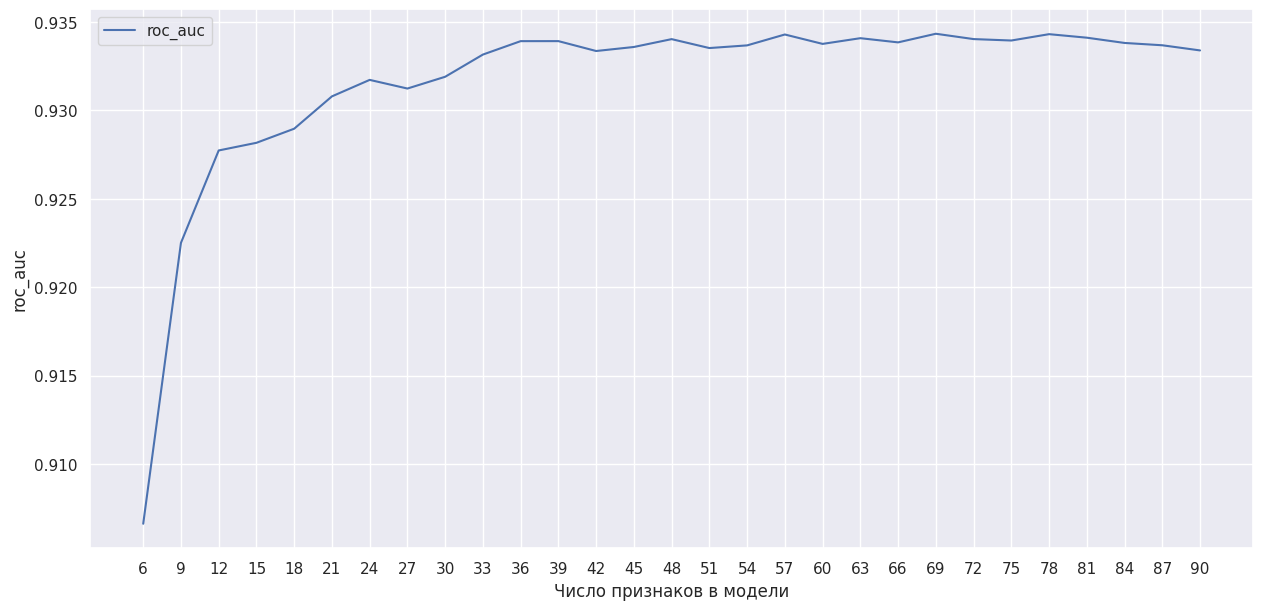

In [57]:
roc_auc_df['num_features'] = roc_auc_df['num_features'].astype(int)

sns.set_theme(font_scale = 1, )
plt.figure(figsize=(15, 7))
sns.lineplot(data=roc_auc_df, x='num_features', y='roc_auc', label='roc_auc')
plt.grid(True)
plt.xlabel('Число признаков в модели')
plt.xticks(roc_auc_df['num_features'].astype(int))
plt.legend()

In [288]:
import optuna

def objective(trial):

    # 1. разделяем случайным образом выборку X_cv, y_cv на обучающую, валидационную и тестовую
    x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    # 2. назначаем параметры и значения для перебора
    param = {
        #"iterations": trial.suggest_int("iterations", 800, 1500),
        "iterations": 1000,
        "learning_rate": 0.1,
        #"depth": trial.suggest_int("depth", 5, 6),
        "depth": 6,
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 100.0, log=True),  # L2 регуляризация

        #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 1),  # Сэмплирование признаков на уровне дерева
        #"bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 10.0),  # Температура бэггинга
        #"random_strength": trial.suggest_float("random_strength", 0.0, 100.0),  # Случайность при построении деревьев
        #"border_count": trial.suggest_int("border_count", 1, 600),  # border_count
        #'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        #'max_depth': trial.suggest_int('max_depth', 1, 10),
        #'random_seed': trial.suggest_int('random_seed', 1, 100)
    }

    # 3. обучаем модель с выбранными параметрами
    model_cv = CatBoostClassifier(**param, cat_features=cat_feat, task_type="GPU",loss_function='MultiClass')
    #model_cv.fit(x_train[selected_features], y_train, eval_set=(x_valid[selected_features], y_valid), early_stopping_rounds=50, verbose=False)
    model_cv.fit(x_train[selected_features], y_train, verbose=False)

    # 4. делаем предсказание и возвращаем значение метрики

    preds = model_cv.predict_proba(x_val[selected_features])
    
    w_roc_auc = weighted_roc_auc(y_val, preds, model_cv.classes_, weights_dict)

    return w_roc_auc

In [289]:
#{'iterations': 1775, 'learning_rate': 0.21685264125461431, 'depth': 8, 'l2_leaf_reg': 0.19457301685397652, 'random_seed': 79}
study = optuna.create_study(direction="maximize")
study.optimize(objective, timeout=300)

[I 2024-03-12 22:44:56,473] A new study created in memory with name: no-name-95ecfb79-a88b-4860-8c04-144e02fce8f1
[I 2024-03-12 22:45:47,731] Trial 0 finished with value: 0.9373930010939892 and parameters: {'l2_leaf_reg': 0.0018526507769338924}. Best is trial 0 with value: 0.9373930010939892.
[I 2024-03-12 22:46:38,469] Trial 1 finished with value: 0.9380004179270336 and parameters: {'l2_leaf_reg': 0.017164657637116033}. Best is trial 1 with value: 0.9380004179270336.
[I 2024-03-12 22:47:28,995] Trial 2 finished with value: 0.9359582569594523 and parameters: {'l2_leaf_reg': 1.272197178127844}. Best is trial 1 with value: 0.9380004179270336.
[I 2024-03-12 22:48:20,271] Trial 3 finished with value: 0.9371937975540138 and parameters: {'l2_leaf_reg': 0.007671998942640469}. Best is trial 1 with value: 0.9380004179270336.
[I 2024-03-12 22:49:11,266] Trial 4 finished with value: 0.9357391921350767 and parameters: {'l2_leaf_reg': 1.899942590905807}. Best is trial 1 with value: 0.93800041792703

In [285]:
optuna.visualization.plot_param_importances(study)

In [15]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

In [16]:
cluster_weights = pd.read_excel("/kaggle/input/it-purple-hack-alpha/cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

In [174]:
y_pred_proba = model.predict_proba(x_val[selected_features]) 
y_pred_proba.shape

(120000, 17)

In [ ]:
0.9541988823186102

In [175]:
weighted_roc_auc(y_val, y_pred_proba, model.classes_, weights_dict)

0.955709274875521

In [ ]:
test_df["start_cluster"]

In [170]:
sample_submission_df = pd.read_csv("/kaggle/input/it-purple-hack-alpha/sample_submission.csv")

In [215]:
sample_submission_df.head()

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
1,200001,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
2,200002,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
3,200003,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
4,200004,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05


In [171]:
last_m_test_df = test_df[test_df["date"] == "month_6"]
last_m_test_df = last_m_test_df.drop(["id", "date"], axis=1)
test_pred_proba = model.predict_proba(last_m_test_df[selected_features])
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=model.classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

In [219]:
test_pred_proba_df.shape

(100000, 17)

In [230]:
test_pred_proba_df.head(100)

,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,0.008675,0.010059,0.023410,0.028885,0.005678,0.000188,0.003140,0.001093,0.027042,0.003275,0.027214,0.000793,0.001786,3.967821e-06,0.008239,0.850509,0.000009
1,0.006029,0.545073,0.000495,0.001147,0.000487,0.000051,0.000098,0.000005,0.001362,0.009212,0.000508,0.000223,0.000390,1.168139e-07,0.000533,0.434205,0.000181
2,0.491878,0.002632,0.003886,0.133132,0.015397,0.000684,0.001117,0.009178,0.063633,0.009114,0.018766,0.015649,0.003610,1.286940e-05,0.103149,0.127798,0.000365
3,0.018699,0.680391,0.000367,0.000589,0.000166,0.000529,0.000142,0.000051,0.000490,0.034995,0.001714,0.000036,0.000906,6.716356e-08,0.000212,0.260705,0.000009
4,0.047636,0.125730,0.014337,0.013702,0.000789,0.001073,0.000197,0.000096,0.006410,0.092583,0.004826,0.000073,0.007680,2.313996e-07,0.000340,0.684521,0.000006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.075741,0.290097,0.000195,0.000527,0.000051,0.000748,0.000269,0.000014,0.000983,0.137451,0.000668,0.000045,0.000222,4.745067e-08,0.000174,0.492812,0.000001
96,0.005968,0.509434,0.000572,0.001774,0.000342,0.000081,0.000220,0.000009,0.000864,0.003178,0.000693,0.000122,0.000241,3.287193e-08,0.000119,0.476382,0.000001
97,0.037252,0.600005,0.001806,0.006458,0.000699,0.000019,0.001447,0.000038,0.000647,0.005101,0.001751,0.000335,0.000164,1.088340e-05,0.001262,0.342568,0.000439
98,0.031311,0.026869,0.021140,0.062859,0.025381,0.000098,0.000365,0.000106,0.014039,0.004852,0.007364,0.003216,0.002650,1.844997e-06,0.001886,0.797841,0.000020


In [50]:
sample_submission_df

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.008290,0.017936,0.033384,0.029434,0.004381,0.000259,0.002000,0.001421,0.010209,0.002587,0.022398,0.000205,0.000961,5.501151e-07,0.003458,0.863068,0.000009
1,200001,0.005533,0.581520,0.000488,0.001432,0.000659,0.000036,0.000112,0.000008,0.001660,0.008938,0.000664,0.000096,0.001223,1.571752e-07,0.000298,0.397168,0.000165
2,200002,0.427380,0.003521,0.001955,0.135300,0.010503,0.000680,0.001319,0.023701,0.091856,0.008549,0.017422,0.014836,0.001274,1.681705e-06,0.049961,0.211623,0.000117
3,200003,0.018511,0.692422,0.000336,0.000629,0.000243,0.000384,0.000099,0.000158,0.000706,0.023218,0.002989,0.000076,0.001008,5.983105e-08,0.000145,0.259071,0.000006
4,200004,0.066491,0.168253,0.010378,0.009161,0.001071,0.001708,0.000263,0.000066,0.009495,0.065212,0.003598,0.000091,0.007802,4.052950e-07,0.000288,0.656121,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,299995,0.025461,0.367640,0.001300,0.006711,0.007496,0.000022,0.000592,0.000005,0.003770,0.000964,0.000853,0.001035,0.000178,8.701694e-06,0.000990,0.582795,0.000178
99996,299996,0.022782,0.044685,0.016422,0.048064,0.006579,0.000101,0.000333,0.000086,0.013382,0.003907,0.012318,0.005406,0.001050,3.303442e-06,0.006060,0.818437,0.000385
99997,299997,0.028238,0.017903,0.032413,0.061892,0.009019,0.000236,0.000627,0.000343,0.015594,0.004984,0.008794,0.000659,0.001808,4.034413e-06,0.027538,0.789947,0.000001
99998,299998,0.054958,0.239949,0.007651,0.043049,0.002264,0.000676,0.000926,0.000188,0.009583,0.015539,0.007505,0.002815,0.000844,3.281376e-06,0.014818,0.598863,0.000371


In [172]:
sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("_submission_54_.csv", index=False)

In [50]:
sample_submission_df.columns

Index(['id', '{other}', '{}', '{α, β}', '{α, γ}', '{α, δ}', '{α, ε, η}',
       '{α, ε, θ}', '{α, ε, ψ}', '{α, ε}', '{α, η}', '{α, θ}', '{α, λ}',
       '{α, μ}', '{α, π}', '{α, ψ}', '{α}', '{λ}'],
      dtype='object')

In [ ]:
#model = CatBoostClassifier(iterations=920, verbose=True, learning_rate=0.1, depth=6, cat_features=cat_cols, task_type="GPU",loss_function='MultiClass')
params = {'iterations': 1411, 'learning_rate': 0.239028351692491, 'depth': 9, 'l2_leaf_reg': 0.32761260321802904, 'random_seed': 12}
#model = CatBoostClassifier(iterations=1000, verbose=True, learning_rate=0.1, random_state=42, depth=8, cat_features=cat_feat, task_type="GPU",loss_function='MultiClass')
model = CatBoostClassifier(**params, cat_features=cat_feat, task_type="GPU",loss_function='MultiClass')
model = CatBoostClassifier(iterations=1000, verbose=True, learning_rate=0.1, random_state=42, depth=8, cat_features=cat_feat, task_type="GPU",loss_function='MultiClass')

#model.fit(x_train[selected_features], y_train, sample_weight=x_train['w'])
#model.fit(x_train[selected_features], y_train)
model.fit(X[selected_features], y)